In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [3]:
#Following lines are to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [45]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = "/sf/alvra/data/p17589/res/JF_pedestals/pedestal_20181028_1746.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V01/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
print("Dimensions of G: ", G.shape)

channel_JFimages = "data/JF02T09V01/data"
channel_pulse_idsJF = "data/JF02T09V01/pulse_id"

channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_pulse_idsBS = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

#channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
#channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
#channel_Izero = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
#channel_Izero2 = "data/SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
#channel_Izero3 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
#channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
#channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
#channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
#channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
#channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
#channel_PALM_drift = "data/SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

Dimensions of G:  (4, 512, 9216)


In [48]:
def LoadData_JF(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids = JF_file[channel_pulse_idsJF][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))       #This is for 10 Hz
       # reprate_FEL = pulse_ids%10 == 0
        reprate_laser = pulse_ids%20 == 0                               #This is for 5 Hz
        
        image_JF_ON = JF_file[channel_JFimages][:,:,:][reprate_laser]
        image_JF_OFF = JF_file[channel_JFimages][:,:,:][reprate_FEL]
        
        image_roi1_ON = image_JF_ON[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_ON = image_JF_ON[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
        image_roi1_OFF = image_JF_OFF[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_OFF = image_JF_OFF[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF, pulse_ids

def LoadData_BS(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_idsBS][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))       #This is for 10 Hz
       # reprate_FEL = pulse_ids%10 == 0
        reprate_laser = pulse_ids%20 == 0                               #This is for 5 Hz
        
        delay = BS_file[channel_delay][:][reprate_FEL]
        energy = BS_file[channel_energy][:][reprate_FEL]
        
    return delay, energy

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [6]:
DIR = "/sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/"
DIR_json = "/sf/alvra/data/p17589/res/scan_info/"

!ls -lah -t /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 569G
drwxrwsr-x.  2 17589 p17589  32K Oct 29 07:12 .
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 07:12 monoscan_20uJ_143p515_Febpy_a_step0028.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 07:09 monoscan_20uJ_143p515_Febpy_a_step0028.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 07:08 monoscan_20uJ_143p515_Febpy_a_step0027.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 07:05 monoscan_20uJ_143p515_Febpy_a_step0027.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 07:05 monoscan_20uJ_143p515_Febpy_a_step0026.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 07:02 monoscan_20uJ_143p515_Febpy_a_step0026.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 07:01 monoscan_20uJ_143p515_Febpy_a_step0025.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 06:58 monoscan_20uJ_143p515_Febpy_a_step0025.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 06:58 monoscan_20uJ_143p515_Febpy_a_step0024.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 06:55 monoscan_20uJ_143p515_Fe

<IPython.core.display.Javascript object>


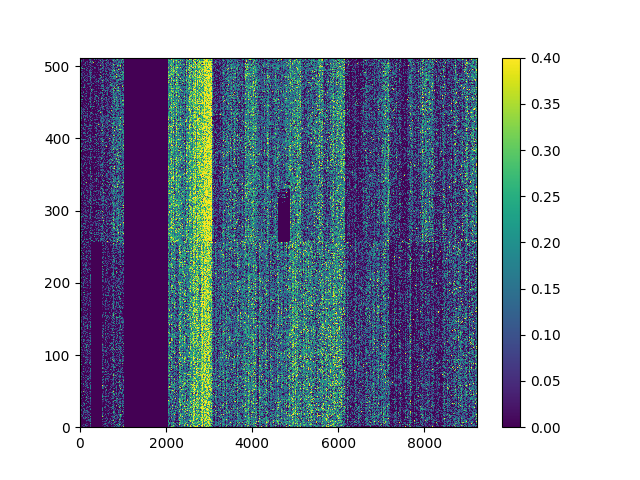

In [7]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "monoscan_20uJ_143p515_Febpy_a_step0000.JF02T09V01.h5"

jf_file = h5py.File(DIR + fileName)

images = jf_file[channel_JFimages]
pulse_ids = jf_file[channel_pulse_idsJF]


nframes = 10

#nframes=images.shape(0)

total = 0
threshold = 2
#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
roi = [[0, images.shape[1]], [0, images.shape[2]]]

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes


plt.figure()
plt.imshow(total, origin="lower", extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]], aspect='auto', vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

In [8]:
# Ka emission 
roi1 = [[225, 325], [6950, 7075]] # both crystals overlapped

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

# Kb emission 
roi2 = [[225, 325], [8250, 8380]] # both crystals overlapped

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]


In [50]:
scan_name ="monoscan_20uJ_143p515_Febpy_a"

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

# Ka emission 

threshold = 2
photon_range = (1, 3)

spectra_ON_roi1 = 0
spectra_OFF_roi1 = 0
spectra_ON_roi2 = 0
spectra_OFF_roi2 = 0

n_spectra_on = 0
n_spectra_off = 0


XAS_trans = []
Energy_eV = []
Delay_mm = []
Error_XAS = []
RIXS_transient = []
Error_transient = []
RIXS_unpumped = []
Error_unpumped = []


for i in range(0,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][1])))
    
    (energy_loop, delay_loop) = LoadData_BS(str(data['scan_files'][i][0]))
    
    energy_loop = [x for x in energy_loop if (x > 0)]     #This is to prevent that some occasional zeros screw up the mean value calculated below
    delay_loop = [x for x in delay_loop if (x > 0)]       #This is to prevent that some occasional zeros screw up the mean value calculated below
    Delay_mm.append(np.mean(delay_loop))
    Energy_eV.append(np.mean(energy_loop))
    
    spectra_ON_roi1 = 0
    spectra_OFF_roi1 = 0
    spectra_ON_roi2 = 0
    spectra_OFF_roi2 = 0
    
    (image_ON_single_roi1,image_OFF_single_roi1,image_ON_single_roi2,image_OFF_single_roi2,pulse_ids) = LoadData_JF(str(data['scan_files'][i][1]))
    
    nframes = np.ma.size(image_ON_single_roi1,0)
    print (nframes)
    
    for j in range(nframes):
        image_ON_2D_roi1 = image_ON_single_roi1[j,:,:]
        image_ON_processed_roi1= ju.apply_gain_pede(image_ON_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_ON_processed_roi1[image_ON_processed_roi1 < threshold] = 0
        image_ON_processed_roi1 = convert_to_photon_num_range(image_ON_processed_roi1)
        spectra_ON_roi1 += image_ON_processed_roi1.sum(axis=0)
        
        image_OFF_2D_roi1 = image_OFF_single_roi1[j,:,:]
        image_OFF_processed_roi1= ju.apply_gain_pede(image_OFF_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_OFF_processed_roi1[image_OFF_processed_roi1 < threshold] = 0
        image_OFF_processed_roi1 = convert_to_photon_num_range(image_OFF_processed_roi1)
        spectra_OFF_roi1 += image_OFF_processed_roi1.sum(axis=0)
    
    XAS_trans.append(spectra_ON_roi1.sum() - spectra_OFF_roi1.sum())    
    XAS_trans = np.asarray(XAS_trans)

/sf/alvra/data/p17589/res/scan_info/monoscan_20uJ_143p515_Febpy_a_scan_info.json
Processing 29 files
step 1 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0000.JF02T09V01.h5
1000
step 2 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0001.JF02T09V01.h5
1000


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [40]:
image_ON_processed_roi1= ju.apply_gain_pede(image_ON_single_roi1[0,:,:], G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
image_ON_processed_roi1[image_ON_processed_roi1 < threshold] = 0
image_ON_processed_roi1 = convert_to_photon_num_range(image_ON_processed_roi1)

<IPython.core.display.Javascript object>


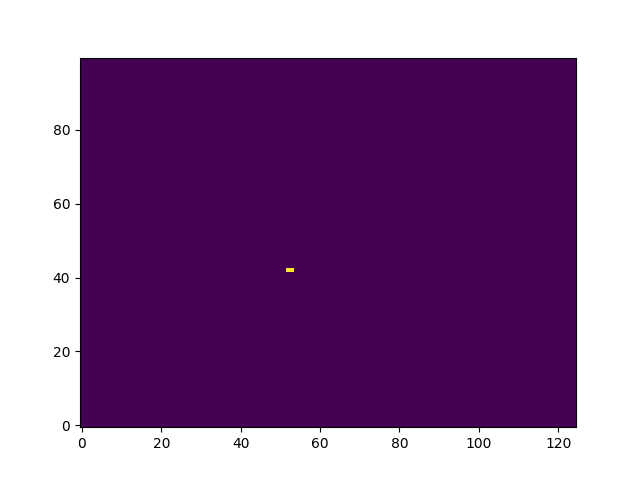

In [41]:
plt.figure()
plt.imshow(image_ON_processed_roi1, origin="lower", aspect='auto')
plt.show()

In [13]:
x_axis = np.arange(roi1[1][0], roi1[1][1])
plt.figure()

plt.subplot(211)
plt.plot(x_axis,spectra_OFF_roi1, label="ROI1, Spectra OFF", marker='.')
plt.legend(loc="best")
plt.title(jf_file)
x_axis = np.arange(roi2[1][0], roi2[1][1])
plt.subplot(212)
plt.plot(x_axis,spectra_OFF_roi2,label="ROI2, Spectra OFF",marker='.')
plt.legend(loc="best")

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (130,) and (1,)

In [33]:
roi1 = [[225, 325], [6950, 7075]] # both crystals overlapped
image_roi1_ON = image_ON_loop[:,roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

In [10]:
print (image_roi1_ON.shape)
print (image_roi1_OFF.shape)

NameError: name 'image_roi1_ON' is not defined

In [12]:
XAS_trans

array([[ -2.,   5.,  -2.,  21.,  15., -16.,  -7.,  -4.,  17.,   2., -16.,
          3.,  16.,  12.,  -5.,  -3., -19.,  -4.,  -8.,   2.,  -7.,  -1.,
          4.,  -6.,   1.,  -4.,  -1., -15., -18.,   9.,  11.,  17.,  -6.,
          1., -11.,  -5.,  23.,  17.,  16.,  19.,  15.,   6., -10.,  -5.,
        -17.,  -9., -24., -20.,  -8., -12.,   3.,  -9.,   4.,  20.,  18.,
         20.,  14., -10.,  19.,  16.,  15.,  -9.,   3.,  25.,  -5., -14.,
         38.,  -6.,  -8.,  -5.,  -2.,   8., -20.,   4.,   3., -19.,  -5.,
         -1.,  14.,  -5.,   8.,   3.,   8.,  13.,  -7.,  18.,  19., -10.,
         16.,  -4.,   0.,  19.,   5.,   0.,  27.,  14.,   5., -10., -16.,
        -37., -14.,   4.,  13.,   1.,  20.,  -8., -14.,  17., -24.,  -5.,
          3.,   3.,   1.,   6.,   4.,   6.,   8.,  -3.,  10.,  15.,  13.,
          9.,  -9.,  -6.,  12.]], dtype=float32)